In [40]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_days = 500
initial_price = 100
annual_drift = 0.05  # 5% annual growth
annual_volatility = 0.20  # 20% annual volatility

# Convert to daily
daily_drift = annual_drift / 252
daily_volatility = annual_volatility / np.sqrt(252)

# Generate price series
dates = pd.date_range(start='2022-01-01', periods=n_days, freq='B')  # Business days
prices = [initial_price]

for i in range(1, n_days):
    # Random shock with volatility clustering
    if i > 20 and abs(prices[i-1] / prices[i-2] - 1) > 0.02:  # If recent big move
        volatility_multiplier = 1.5  # Higher volatility after big moves
    else:
        volatility_multiplier = 1.0
    
    # Daily return with drift and random shock
    daily_return = daily_drift + daily_volatility * volatility_multiplier * np.random.randn()
    
    # Occasional jumps (earnings, news)
    if np.random.random() < 0.02:  # 2% chance of jump
        daily_return += np.random.choice([-0.05, 0.05]) * np.random.random()
    
    # Calculate new price
    new_price = prices[-1] * (1 + daily_return)
    prices.append(new_price)

# Create DataFrame with OHLCV data
df = pd.DataFrame(index=dates)
df['Close'] = prices

# Generate OHLC from Close
daily_range = df['Close'] * 0.02  # 2% typical daily range
df['Open'] = df['Close'] + daily_range * (np.random.random(n_days) - 0.5)
df['High'] = np.maximum(df['Open'], df['Close']) + daily_range * np.random.random(n_days) * 0.5
df['Low'] = np.minimum(df['Open'], df['Close']) - daily_range * np.random.random(n_days) * 0.5

# Generate volume (correlated with price changes)
base_volume = 10_000_000
price_changes = abs(df['Close'].pct_change()).fillna(0)
df['Volume'] = base_volume * (1 + price_changes * 20 + np.random.random(n_days) * 0.3)
df['Volume'] = df['Volume'].astype(int)

print(df.head())
print(f"\nPrice range: ${df['Close'].min():.2f} - ${df['Close'].max():.2f}")

                 Close        Open        High        Low    Volume
2022-01-03  100.000000  100.649362  101.189319  99.180936  10894156
2022-01-04  100.645642  100.339295  101.493112  99.795010  11607379
2022-01-05  100.490290  100.848068  101.371580  99.776565  12654182
2022-01-06  100.213777  100.345522  100.970441  99.898755  12482776
2022-01-07   99.938045   99.472390  100.027114  99.001514  10694845

Price range: $96.54 - $149.16


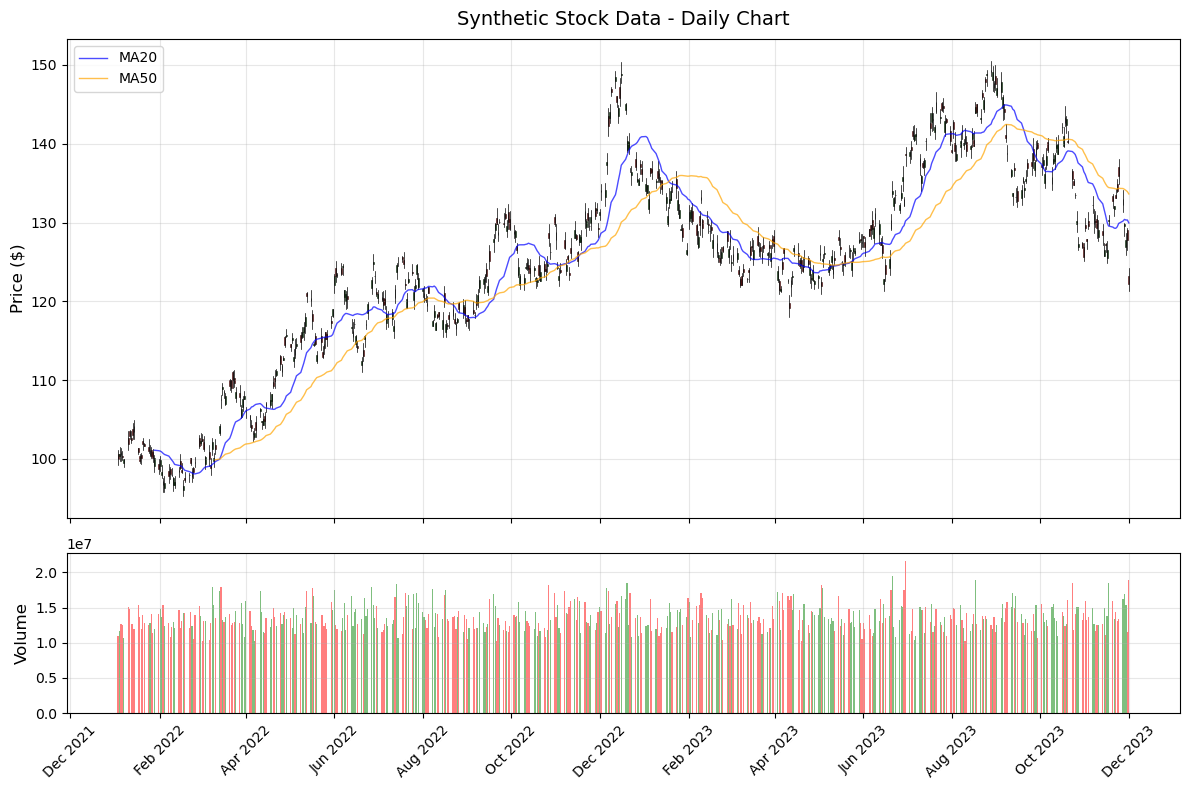


Summary Statistics:
Starting Price: $100.00
Ending Price: $122.20
Total Return: 22.2%
Volatility (annualized): 21.9%


In [31]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), height_ratios=[3, 1], sharex=True)
fig.patch.set_facecolor('white')

# Plot candlestick chart
for idx, row in df.iterrows():
    open_price = row['Open']
    close_price = row['Close']
    high_price = row['High']
    low_price = row['Low']
    
    # Determine color
    color = 'green' if close_price > open_price else 'red'
    
    # Draw high-low line
    ax1.plot([idx, idx], [low_price, high_price], color='black', linewidth=0.5)
    
    # Draw open-close rectangle
    height = abs(close_price - open_price)
    bottom = min(open_price, close_price)
    rect = Rectangle((mdates.date2num(idx) - 0.3, bottom), 0.6, height, 
                     facecolor=color, edgecolor='black', linewidth=0.5, alpha=0.8)
    ax1.add_patch(rect)

# Add moving averages
df['MA20'] = df['Close'].rolling(20).mean()
df['MA50'] = df['Close'].rolling(50).mean()
ax1.plot(df.index, df['MA20'], 'blue', linewidth=1, label='MA20', alpha=0.7)
ax1.plot(df.index, df['MA50'], 'orange', linewidth=1, label='MA50', alpha=0.7)

# Format price chart
ax1.set_ylabel('Price ($)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')
ax1.set_title('Synthetic Stock Data - Daily Chart', fontsize=14, pad=10)

# Plot volume
colors = ['green' if df['Close'].iloc[i] > df['Open'].iloc[i] else 'red' for i in range(len(df))]
ax2.bar(df.index, df['Volume'], color=colors, alpha=0.5, width=0.8)
ax2.set_ylabel('Volume', fontsize=12)
ax2.grid(True, alpha=0.3)

# Format x-axis
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"Starting Price: ${df['Close'].iloc[0]:.2f}")
print(f"Ending Price: ${df['Close'].iloc[-1]:.2f}")
print(f"Total Return: {((df['Close'].iloc[-1] / df['Close'].iloc[0]) - 1) * 100:.1f}%")
print(f"Volatility (annualized): {df['Close'].pct_change().std() * np.sqrt(252) * 100:.1f}%")

In [32]:
# Create sequences for time series prediction
def create_sequences(data, n_past=30, n_future=1):
    X, y = [], []
    for i in range(n_past, len(data) - n_future + 1):
        X.append(data[i - n_past:i])
        y.append(data[i:i + n_future])
    return np.array(X), np.array(y)

# Use only Close prices for now
prices = df['Close'].values

# Normalize the data (important for neural networks)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices.reshape(-1, 1)).flatten()

# Create sequences
X, y = create_sequences(prices_scaled, n_past=30, n_future=1)

print(f"Input shape: {X.shape}")
print(f"Output shape: {y.shape}")
print(f"Number of samples: {len(X)}")
print(f"\nExample:")
print(f"Input (last 5 days): {X[0][-5:]}")
print(f"Target (next day): {y[0]}")

# Split into train/test
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"\nTrain samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Input shape: (470, 30)
Output shape: (470, 1)
Number of samples: 470

Example:
Input (last 5 days): [0.02499542 0.02937895 0.02703311 0.02034086 0.00994465]
Target (next day): [0.03487501]

Train samples: 376
Test samples: 94


In [33]:
# Create DataFrame in TFT format
def create_tft_dataframe(X, y, start_idx=0):
    records = []
    
    for i in range(len(X)):
        # Add historical data
        for j in range(len(X[i])):
            records.append({
                'time_idx': start_idx + i * 31 + j,  # Continuous time index
                'sequence_id': i,  # Which sequence this belongs to
                'price': X[i][j],
                'position': j,  # Position in sequence (0-29)
                'is_target': 0  # Not a target
            })
        
        # Add target
        records.append({
            'time_idx': start_idx + i * 31 + 30,
            'sequence_id': i,
            'price': y[i][0],
            'position': 30,  # Target position
            'is_target': 1  # This is the target
        })
    
    return pd.DataFrame(records)

# Create train and test DataFrames
train_df = create_tft_dataframe(X_train, y_train, start_idx=0)
test_df = create_tft_dataframe(X_test, y_test, start_idx=len(X_train) * 31)

# Add time features
train_df['day_of_week'] = train_df['time_idx'] % 5  # Simplified weekday
train_df['position_normalized'] = train_df['position'] / 30

test_df['day_of_week'] = test_df['time_idx'] % 5
test_df['position_normalized'] = test_df['position'] / 30

print(f"Train DataFrame shape: {train_df.shape}")
print(f"Test DataFrame shape: {test_df.shape}")
print("\nSample of train data:")
print(train_df.head(35))  # Show transition from sequence to target
print(f"\nUnique sequences in train: {train_df['sequence_id'].nunique()}")

Train DataFrame shape: (11656, 7)
Test DataFrame shape: (2914, 7)

Sample of train data:
    time_idx  sequence_id     price  position  is_target  day_of_week  \
0          0            0  0.065827         0          0            0   
1          1            0  0.078096         1          0            1   
2          2            0  0.075144         2          0            2   
3          3            0  0.069890         3          0            3   
4          4            0  0.064650         4          0            4   
5          5            0  0.102812         5          0            0   
6          6            0  0.121927         6          0            1   
7          7            0  0.110743         7          0            2   
8          8            0  0.124426         8          0            3   
9          9            0  0.130786         9          0            4   
10        10            0  0.083804        10          0            0   
11        11            0  0.059707

In [34]:
# First install required libraries (run this in a cell)
# !pip install pytorch-forecasting pytorch-lightning

import pytorch_forecasting
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.metrics import MAE
import pytorch_lightning as pl
import torch

# Create a proper continuous dataset
# Instead of separate sequences, we'll use the original time series

# Prepare the original data in the right format
tft_data = pd.DataFrame()
tft_data['time_idx'] = range(len(prices_scaled))
tft_data['price'] = prices_scaled
tft_data['group'] = 0  # Single time series
tft_data['day_of_week'] = tft_data['time_idx'] % 5
tft_data['position_normalized'] = (tft_data['time_idx'] % 30) / 30

# For TFT, the target is the same as price (we're predicting future prices)
tft_data['target'] = tft_data['price']

# Split into train/test
train_cutoff = int(0.8 * len(tft_data))
train_data = tft_data[:train_cutoff].copy()
test_data = tft_data[train_cutoff:].copy()

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print("\nSample of data:")
print(train_data.head())

# Create TimeSeriesDataSet for TFT
max_encoder_length = 30
max_prediction_length = 1

training = TimeSeriesDataSet(
   train_data,
   time_idx="time_idx",
   target="target",
   group_ids=["group"],
   min_encoder_length=max_encoder_length,
   max_encoder_length=max_encoder_length,
   min_prediction_length=max_prediction_length,
   max_prediction_length=max_prediction_length,
   time_varying_known_reals=["time_idx", "day_of_week", "position_normalized"],
   time_varying_unknown_reals=["price"],
   target_normalizer=pytorch_forecasting.data.encoders.GroupNormalizer(
       groups=["group"], transformation="softplus"
   ),
   add_relative_time_idx=True,
   add_target_scales=True,
   add_encoder_length=True,
)

# Create validation dataset from the last part of training data
validation = TimeSeriesDataSet.from_dataset(training, train_data, predict=True, stop_randomization=True)

# Create dataloaders
batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

print(f"\nNumber of training samples: {len(training)}")
print(f"Number of validation samples: {len(validation)}")

Train data shape: (400, 6)
Test data shape: (100, 6)

Sample of data:
   time_idx     price  group  day_of_week  position_normalized    target
0         0  0.065827      0            0             0.000000  0.065827
1         1  0.078096      0            1             0.033333  0.078096
2         2  0.075144      0            2             0.066667  0.075144
3         3  0.069890      0            3             0.100000  0.069890
4         4  0.064650      0            4             0.133333  0.064650

Number of training samples: 370
Number of validation samples: 1


In [35]:
# Create TFT model with smaller architecture for CPU
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,  # Small hidden size for CPU
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=pytorch_forecasting.metrics.QuantileLoss(),
    log_interval=10,  # Log every 10 batches
    reduce_on_plateau_patience=4,
)

print(f"Number of parameters: {sum(p.numel() for p in tft.parameters()):,}")

# Create trainer for CPU
trainer = pl.Trainer(
    max_epochs=30,  # Quick training
    accelerator='cpu',  # Force CPU
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # Limit batches since we have small dataset
    enable_checkpointing=False,
    logger=False,  # Disable logging for simplicity
)

print("\nReady to train the model!")
print(f"Training samples: {len(training)}")
print(f"Batch size: {batch_size}")
print(f"Steps per epoch: {len(train_dataloader)}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters: 21,321

Ready to train the model!
Training samples: 370
Batch size: 64
Steps per epoch: 5


In [38]:
# Create test dataloader
test_dataset = TimeSeriesDataSet.from_dataset(
   training, 
   test_data, 
   predict=True, 
   stop_randomization=True
)

test_dataloader = test_dataset.to_dataloader(
   train=False, 
   batch_size=64, 
   num_workers=0
)

print(f"Test dataloader created with {len(test_dataloader)} batches")

# Now make predictions
print("\nMaking predictions (untrained model)...")
predictions = tft.predict(test_dataloader)

print(f"Predictions type: {type(predictions)}")
print(f"Predictions shape: {predictions.shape if hasattr(predictions, 'shape') else 'Not a tensor'}")

Test dataloader created with 1 batches

Making predictions (untrained model)...
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([1, 1])
